In [ ]:
#!pip install -q torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
#!pip install -q --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install torch-geometric

In [ ]:
#!pip install ipython

In [1]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from sklearn.neural_network import MLPClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier
from torch_geometric.data import NeighborSampler
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import collections
from concurrent.futures import ThreadPoolExecutor
import numpy as np
from modules.model import Net
from modules.sampling import Sampler

In [2]:
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = data.x.to(device)
y = data.y.squeeze().to(device)

In [8]:
train_mask = torch.tensor([True]*int(0.6*len(data.x)+1) + [False]*int(0.4*len(data.x)))
val_mask = torch.tensor([False]*int(0.6*len(data.x)+1) + [True]*int(0.2*len(data.x)+1)+[False]*int(0.2*len(data.x)))
test_mask = torch.tensor([False]*int(0.6*len(data.x)+1) + [False]*int(0.2*len(data.x)+1)+[True]*int(0.2*len(data.x)))

In [9]:
arr=torch.nonzero(train_mask == True)
indices_of_train_data = ([item for sublist in arr for item in sublist])

In [10]:
num_layers = 2
train_loader = NeighborSampler(data.edge_index, node_idx=torch.tensor([True]*len(data.x),dtype = torch.bool), batch_size = 256, sizes=[10]*num_layers,
                               shuffle=True)
from sklearn.metrics import precision_score
def train(model,data,optimizer,Sampler):
    model.train()        
    total_loss = 0
    optimizer.zero_grad()
    if model.mode == 'unsupervised':
        if model.conv=='GCN':
            out = model.inference(data.to(device),dp=dropout)
            samples = Sampler.sample(indices_of_train_data)
            
            loss = model.loss(out[train_mask], samples)
            total_loss+=loss
        else:
            for batch_size, n_id, adjs in train_loader:
                # adjs holds a list of (edge_index, e_id, size) tuples.
                adjs = [adj.to(device) for adj in adjs]
                out = model.forward(data.x[n_id].to(device), adjs)
                samples = Sampler.sample(list(collections.Counter((adjs[num_layers - 1].edge_index[1]).tolist()).keys()))

                loss = model.loss(out, samples)#pos_batch.to(device), neg_batch.to(device))
                total_loss+=loss
        total_loss.backward()
        optimizer.step()      
        return total_loss /len(train_loader)
    elif model.mode== 'supervised':
        if model.conv=='GCN':
            out = model.inference(data.to(device),dp=dropout)
            loss = model.loss_sup(out[train_mask],y[train_mask])
            total_loss+=loss
        else:
            for batch_size, n_id, adjs in train_loader:
                adjs = [adj.to(device) for adj in adjs]
                out = model.forward(data.x[n_id].to(device), adjs)
                loss = model.loss_sup(out,y[n_id[:batch_size]])
                total_loss+=loss
        total_loss.backward(retain_graph=True)
        optimizer.step()      
        return total_loss /len(train_loader)       

@torch.no_grad()
def test(model,data): 
    model.eval()
    out = model.inference(data.to(device))
    y_true = y.cpu().detach().numpy()
    if model.mode == 'supervised':
        y_true = y.cpu().unsqueeze(-1)
        y_pred = out.cpu().argmax(dim=-1, keepdim=True)
        accs = []
        for mask in [train_mask, val_mask, test_mask]:    
            accs+=[int(y_pred[mask].eq(y_true[mask]).sum()) / int(mask.sum())]
        return accs
    elif model.mode == 'unsupervised': 
        clf = LogisticRegression(max_iter = 300).fit(out.cpu().detach()[train_mask].numpy(), y.cpu().detach()[train_mask].numpy())
        #clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_depth=3, random_state=0).fit(out.cpu().detach()[train_mask].numpy(), y.cpu().detach()[train_mask].numpy())
        #clf = MLPClassifier(random_state=1, max_iter=3000).fit(out.cpu().detach()[train_mask].numpy(), y.cpu().detach()[train_mask].numpy())
        
        accs = []
        for mask in [train_mask,val_mask, test_mask]:    
            accs += [(clf.score(out.cpu().detach()[mask].numpy(), y.cpu().detach()[mask].cpu().numpy()))]
        return accs
        
        #return [precision_score(y_true[train_mask.cpu()], best_preds_train, average='macro'), precision_score(y_true[val_mask.cpu()], best_preds_val, average='macro'),precision_score(y_true[test_mask.cpu()], best_preds, average='macro')]
    

**Для начала посмотрим, что получится, если передать только фичи. Без обучения**

In [ ]:
#в датасете планетоид все фичи это 0 кроме какой-то одной, не уверена, что это актуальное сравнение 
from sklearn.metrics import accuracy_score
y_true = y.cpu().detach().numpy()
clf = MLPClassifier(random_state=1, max_iter=3000).fit(x[train_mask].cpu().detach().numpy(),y_true[train_mask])
y_pred = clf.predict(x.cpu().detach().numpy())

results = []
for mask in [train_mask, val_mask, test_mask]:  
    results += [(clf.score(x.cpu().detach()[mask].numpy(), y.cpu().detach()[mask].numpy()))]
log = 'Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
print(log.format(results[0], results[1], results[2]))        

**Теперь сравним с результатом после обучения эмбедингов**

conv: SAGE, mode: unsupervised, loss from SAGE
Loss: 1.4806, Epoch: 000, Train: 0.2942, Val: 0.3100, Test: 0.3179
Loss: 1.4373, Epoch: 001, Train: 0.2942, Val: 0.3100, Test: 0.3179
Loss: 1.4105, Epoch: 002, Train: 0.2942, Val: 0.3100, Test: 0.3179
Loss: 1.3956, Epoch: 003, Train: 0.3003, Val: 0.3137, Test: 0.3179
Loss: 1.3889, Epoch: 004, Train: 0.3231, Val: 0.3506, Test: 0.3161
Loss: 1.3887, Epoch: 005, Train: 0.3378, Val: 0.3579, Test: 0.3216
Loss: 1.3883, Epoch: 006, Train: 0.3403, Val: 0.3616, Test: 0.3161
Loss: 1.3853, Epoch: 007, Train: 0.3465, Val: 0.3672, Test: 0.3161
Loss: 1.3852, Epoch: 008, Train: 0.3422, Val: 0.3708, Test: 0.3142
Loss: 1.3948, Epoch: 009, Train: 0.3391, Val: 0.3616, Test: 0.3050
Loss: 1.3871, Epoch: 010, Train: 0.3403, Val: 0.3616, Test: 0.3142
Loss: 1.3845, Epoch: 011, Train: 0.3366, Val: 0.3542, Test: 0.3068
Loss: 1.3792, Epoch: 012, Train: 0.3354, Val: 0.3561, Test: 0.3124
Loss: 1.3789, Epoch: 013, Train: 0.3434, Val: 0.3653, Test: 0.3235
Loss: 1.3786, E

Loss: 1.1043, Epoch: 122, Train: 0.7323, Val: 0.7306, Test: 0.7006
Loss: 1.1059, Epoch: 123, Train: 0.7342, Val: 0.7325, Test: 0.7061
Loss: 1.1127, Epoch: 124, Train: 0.7366, Val: 0.7306, Test: 0.7079
Loss: 1.1000, Epoch: 125, Train: 0.7366, Val: 0.7288, Test: 0.7061
Loss: 1.1194, Epoch: 126, Train: 0.7366, Val: 0.7288, Test: 0.7079
Loss: 1.1178, Epoch: 127, Train: 0.7385, Val: 0.7362, Test: 0.7135
Loss: 1.1294, Epoch: 128, Train: 0.7403, Val: 0.7362, Test: 0.7153
Loss: 1.0950, Epoch: 129, Train: 0.7403, Val: 0.7362, Test: 0.7172
Loss: 1.1073, Epoch: 130, Train: 0.7415, Val: 0.7380, Test: 0.7227
Loss: 1.1129, Epoch: 131, Train: 0.7434, Val: 0.7399, Test: 0.7246
Loss: 1.1062, Epoch: 132, Train: 0.7422, Val: 0.7380, Test: 0.7264
Loss: 1.1562, Epoch: 133, Train: 0.7465, Val: 0.7380, Test: 0.7283
Loss: 1.1143, Epoch: 134, Train: 0.7471, Val: 0.7325, Test: 0.7320
Loss: 1.1168, Epoch: 135, Train: 0.7508, Val: 0.7343, Test: 0.7301
Loss: 1.0962, Epoch: 136, Train: 0.7508, Val: 0.7325, Test: 0.

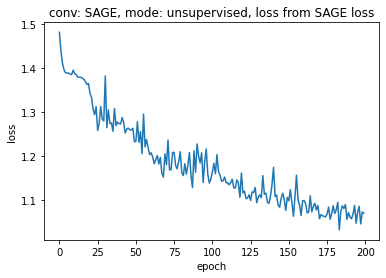

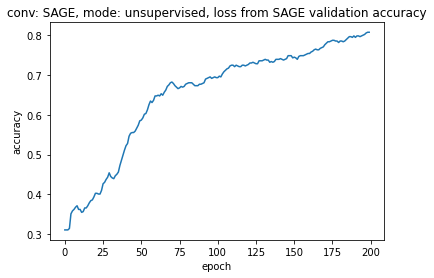

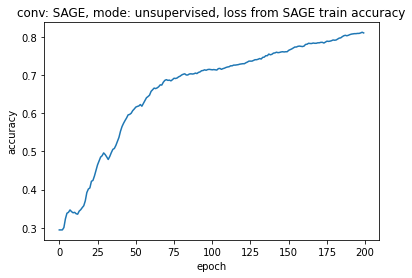

In [47]:
#models = [Net(dataset = dataset,mode='supervised',conv='GCN',device=device), Net(dataset = dataset,mode='supervised',conv='GAT',device=device),Net(dataset = dataset,mode='supervised',conv='SGC',device=device), Net(dataset = dataset,mode='unsupervised',conv='GCN',device=device),Net(dataset = dataset,mode='unsupervised',conv='GAT',device=device),Net(dataset = dataset,mode='unsupervised',conv='SAGE',device=device)]

SAGE = {"Name":"SAGE" , "walk length":5,"walks per node":50,"num negative samples":20,"context size" : 10,"p":1,"q":1, "loss var": "Random Walks"}
DeepWalk = {"Name": "DeepWalk","walk length":40,"walks per node":80,"num negative samples":20,"context size" : 10,"p":1,"q":1,"loss var": "Random Walks" } #Проблемы с памятью после того, как увеличила количество тренировочных данных
Node2Vec = {"Name": "Node2Vec","walk length":100,"walks per node":18,"num negative samples":20,"context size" : 16,"p":1.414 ,"q":1.414, "loss var": "Random Walks"}#то же самое 
LINE2 = {"Name": "LINE2","C": "Adj","num negative samples":1,"loss var": "Context Matrix"}
VERSE_PPR =  {"Name": "VERSE","C": "PPR","num negative samples":1,"loss var": "Context Matrix"} 
GraphFactorization = {"Name": "Graph Factorization","C":"Adj","loss var": "Factorization"}
HOPE_Katz = {"Name": "HOPE: Katz","C":"Katz","loss var": "Factorization"}
HOPE_RPR = {"Name": "HOPE: RPR","C":"RPR","loss var": "Factorization"}

for Conv in ['SAGE']:
    for loss in [SAGE]:
        LossSampler = Sampler(data,device=device,mask=train_mask,loss_info=loss)
        model = Net(dataset = dataset,mode='unsupervised',conv=Conv,loss_function=loss["loss var"],device=device,hidden_layer=64,out_layer =128,num_layers = num_layers)
        model.to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005,weight_decay = 1e-5)
        #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
        #lr_scheduler.StepLR(optimizer, step_size=30,gamma=0.01)
        losses=[]
        train_accs=[]
        test_accs=[]
        val_accs=[]
        name_of_plot='conv: '+model.conv+', mode: '+model.mode+', loss from '+loss["Name"]
       
        print(name_of_plot)
        
        for epoch in range(0,200):
            loss = train(model,data,optimizer,LossSampler)
            losses.append(loss)
            train_acc, val_acc, test_acc = test(model,data)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            val_accs.append(val_acc)
            log = 'Loss: {:.4f}, Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
         #   scheduler.step(loss)
            print(log.format(loss, epoch, train_acc, val_acc, test_acc))
        print('Validation acc on the last epoch ', val_acc)
        plt.plot(losses)
        plt.title(name_of_plot+' loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()


        plt.plot(val_accs)
        plt.title(name_of_plot+' validation accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()
        
        plt.plot(train_accs)
        plt.title(name_of_plot+' train accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()
